In [11]:
import numpy as np
import random
random.seed(123)
class JackEs():
    def __init__(self):
        self.actions = {'hit':0 , 'stick': 1}
        self.pack = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10 ,10, 10]
        self.list_states()
        self.init_vq()
    def pick_card(self):
        return np.random.choice(self.pack)
    
    def generate_dealer_card(self, card):
        pick_2 = self.pick_card()
        cards = [pick_2, card]
        for i, value in enumerate(cards):
            if value == 1:
                if 10 + sum(cards) <=21:
                    cards[i] =  11
                    return sum(cards), True

        return sum(cards), False
        
    
    def list_states(self):
        self.states = []
        
        for i in range(4, 22):
            for j in range(1,11):
                self.states.append((i, j, True))
                self.states.append((i, j, False))
        
    
    def init_vq(self):
        self.q_sa = {}
        self.pi_s = {}
        
        for i in self.states:
            self.q_sa[(i, 0)] = [0. , 0]
            self.q_sa[(i, 1)] = [0. , 0]
            self.pi_s[i] = 0
    
    def add_card_to_hand(self, card, player_cards, player_values):
#         print('Received card', card, player_cards)
        
        player_cards.append(card)
        if card != 1:
            
            player_values.append(card)
        else:
            if sum(player_values) + 11 <= 21:
                player_values.append(11)
            else:
                player_values.append(1)
    
    def generate_episodes(self, pi_s):
        init_state = random.choice(self.states)
#         print(init_state)
        
        episode_states = []
        episode_actions = []
        episode_rewards = []
        
        player_sum = init_state[0]
        dealer_card = init_state[1]
        usable_ace = init_state[-1]
#         print('player_sum',player_sum, 'dealer_card', dealer_card, 'usable_ace',usable_ace)
        dealer_sum, dealer_ace = self.generate_dealer_card(dealer_card)
        
        iter = 0
        done = False
        
        while not done:
#             print('iter', iter)
            episode_states.append((player_sum, dealer_card, usable_ace))
            if iter == 0:
                action = np.random.choice([0,1],p=[0.5, 0.5])
            else:
                action = pi_s[episode_states[-1]]
            episode_actions.append(action)
            
            if action == self.actions['hit']:
                next_card = self.pick_card()
#                 print('hit', episode_states[-1])
                if next_card + player_sum <= 21:
                    
                    if next_card == 1 and player_sum + 11 <= 21:
                        next_card = 11
                        usable_ace = True
                        
                    player_sum += next_card
                    done = False
                    reward = 0
                else:
                    if usable_ace:
                        if player_sum + next_card - 10 <= 21:
                            player_sum += (next_card -10)
                            usable_ace = False
                            done = False
                            reward = 0
                        else:
                            done = True
                            reward = -1
                            episode_rewards.append(reward)
                            break
                    else:
                        done = True
                        reward = -1
                        episode_rewards.append(reward)
                        break
            
            elif action == self.actions['stick']:
#                 printplot_graph(global_dict)
plot_graph(global_dict, True)('stick')
                done = True
                while dealer_sum < 17:
                    next_d_card = self.pick_card()
                    if dealer_sum + next_d_card > 21:
                        if dealer_ace:
                            
                            dealer_ace = False
                            dealer_sum += next_d_card -10
                            
                        else:
                            dealer_sum += next_d_card
                    else:
                        dealer_sum += next_d_card
                        if next_d_card == 1 and (dealer_sum + 10) <= 21:
                            dealer_sum += 10
                            dealer_ace = True
                
                if dealer_sum > 21:
                    reward = 1
                    episode_rewards.append(1)
                    break
                
                else:
                    if dealer_sum == player_sum:
                        reward = 0
                    elif (21 - dealer_sum) < (21 - player_sum):
                        reward = -1
                    elif (21 - dealer_sum) > (21 - player_sum):
                        reward = 1
                    
            episode_rewards.append(reward)                            
            iter += 1
            
        return episode_states, episode_rewards, episode_actions
    
    
    def run(self, episodes=10):
        for episode in range(episodes):
            if episode % 1 == 0:
                print(episode)
            states, rewards, actions = self.generate_episodes()
            print('Length', len(states))
            G = 0
            for i in reversed(range(len(states))):
                G += rewards[i]
                self.q_sa[(states[i], actions[i])][0] = \
                    (self.q_sa[(states[i], actions[i])][0] * self.q_sa[(states[i], actions[i])][1]\
                     + G) / (self.q_sa[(states[i], actions[i])][1] + 1)
                self.q_sa[(states[i], actions[i])][1] += 1
            
                self.pi_s[states[i]] = np.argmax([self.q_sa[(states[i], 0)], self.q_sa[(states[i], 1)]])
                
        

The plots are rotated according to image display

0
100000
200000
300000
400000


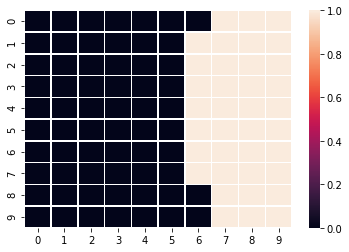

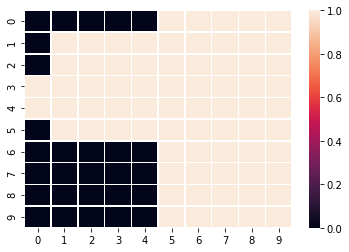

In [14]:
%matplotlib inline
jack = JackEs()
# jack.run(100)
q_sa = {}
pi_s = {}

for i in jack.states:
    q_sa[(i, 0)] = [0. , 0]
    q_sa[(i, 1)] = [0. , 0]
    pi_s[i] = 0

episodes = 500000
for episode in range(episodes):
    G = 0
    if episode % 100000 == 0:
        print(episode)
    states, rewards, actions = jack.generate_episodes(pi_s)
    for j in reversed(range(len(states))):
        G += rewards[j] 
        q_sa[(states[j], actions[j])][0] = (q_sa[(states[j], actions[j])][0] *\
                                            q_sa[(states[j], actions[j])][1] + G) \
                                    / (q_sa[(states[j], actions[j])][1]+1)
        q_sa[(states[j], actions[j])][1] += 1
        if q_sa[(states[j], 0)] > q_sa[(states[j], 1)]:
            pi_s[states[j]] = 0
        else:
            pi_s[states[j]] = 1

        
subset_states =  []
for value in pi_s.keys():
#     print(value)
    if value[0] >= 12:
        subset_states.append(value)   
        
usable_ace_states = []
non_usable_ace_states = []
for state in subset_states:
    if state[-1] == True:
        usable_ace_states.append(state)
    else:
        non_usable_ace_states.append(state)
mat = np.zeros((10, 10))
for state in usable_ace_states:
    value = pi_s[state]
    mat[state[1]-1, state[0]-12] = value
    
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()
ax = sns.heatmap(mat, linewidth=0.5)
fig.savefig('usable.png')
mat = np.zeros((10, 10))
fig = plt.figure()
for state in non_usable_ace_states:
    value = pi_s[state]
    mat[state[1]-1, state[0]-12] = value
ax = sns.heatmap(mat, linewidth=0.5)
fig.savefig('non_usable.png')

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [32]:
def get_value(dict_val, val):
    state_list = [key[0] for key in dict_val.keys()]
    if val not in state_list:
        return [0,0]
    else:
        if dict_val[(val, 0 )] > dict_val[(val, 1)]:
            return dict_val[(val, 0)] 
        return dict_val[(val, 1)]

def plot_graph(dict_val, usable_ace=False):
    states = []
    values = []
    X = []
    Y = []
    Z = []
    init_states = list(dict_val.keys())
#     print(init_states)
    for i in range(len(dict_val.keys())):
        
        if init_states[i][0][-1] == usable_ace and init_states[i][0][0] >= 12:
            states.append(init_states[i])
            values.append(dict_val[init_states[i]])
    x_range = np.arange(11, 22) # player sums 
    y_range = np.arange(1, 11) # visible dealer card 
    X, Y = np.meshgrid(x_range, y_range)

    Z = np.array([get_value(dict_val, (x, y, usable_ace))[0] for x,y in zip(np.ravel(X), np.ravel(Y))])\
    .reshape(X.shape)
    # corresponding values
#     print(Z.shape) 

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,Z)
    ax.set_title(usable_ace)
    ax.set_xlabel('Player sum')
    ax.set_ylabel('Dealer card')
    ax.set_zlabel('Value')
    plt.show()



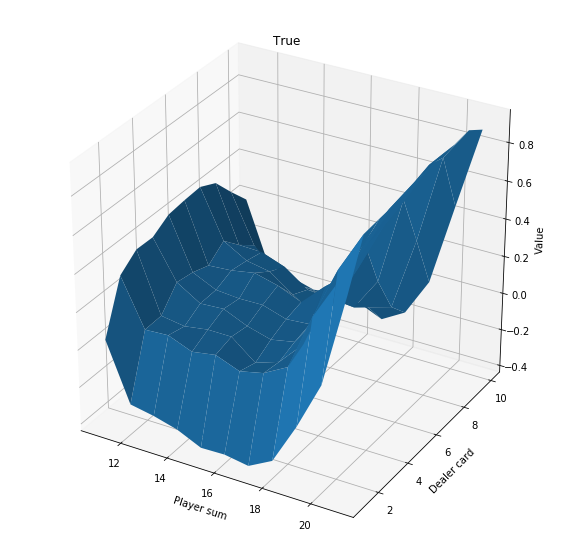

In [33]:
plot_graph(q_sa, True)

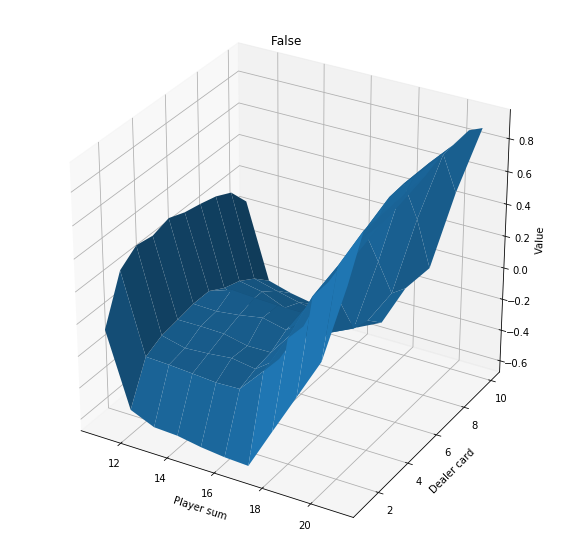

In [34]:
plot_graph(q_sa, False)